In [1]:
# Load datasets
from datasets import load_dataset

train_dataset = load_dataset(
    "csv",
    data_files="https://huggingface.co/datasets/RatchapolSamalee/Wongnai2025_augment_data_for_fine-tuning/resolve/main/Augmented_train_data_newsample_3x.csv"
)["train"]

test_dataset = load_dataset(
    "csv",
    data_files="https://huggingface.co/datasets/RatchapolSamalee/Wongnai2025_augment_data_for_fine-tuning/resolve/main/test_data.csv"
)["train"]

val_dataset = load_dataset(
    "csv",
    data_files="https://huggingface.co/datasets/RatchapolSamalee/Wongnai2025_augment_data_for_fine-tuning/resolve/main/validate_data.csv"
)["train"]

print(train_dataset)
print(test_dataset)
print(val_dataset)

Dataset({
    features: ['review_body', 'labels', 'is_synthesis'],
    num_rows: 43560
})
Dataset({
    features: ['review_body', 'stars', 'labels'],
    num_rows: 3112
})
Dataset({
    features: ['review_body', 'stars', 'labels'],
    num_rows: 1556
})


In [2]:
# แยก Original และ Augmented data
def is_augmented(example):
    return example.get("is_synthesis", 0) == 1

print("\nSeparating original and augmented data")
augmented_train = train_dataset.filter(lambda x: is_augmented(x))
original_train = train_dataset.filter(lambda x: not is_augmented(x))

print(f"Original training samples: {len(original_train)}")
print(f"Augmented training samples: {len(augmented_train)}")


Separating original and augmented data
Original training samples: 10890
Augmented training samples: 32670


In [3]:
# Tokenization
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")

def preprocess_function(examples):
    return tokenizer(
        examples["review_body"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

print("\nTokenizing datasets")
original_train = original_train.map(preprocess_function, batched=True)
augmented_train = augmented_train.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)



Tokenizing datasets


In [4]:
# Label encoding
label_map = {"negative": 0, "positive": 1}

def encode_labels(example):
    if "labels" in example and isinstance(example["labels"], str):
        return {"labels": label_map[example["labels"]]}
    return example

print("\nEncoding labels")
original_train = original_train.map(encode_labels)
augmented_train = augmented_train.map(encode_labels)
val_dataset = val_dataset.map(encode_labels)
test_dataset = test_dataset.map(encode_labels)



Encoding labels


In [5]:
# Shuffle datasets
print("\nShuffling datasets")
original_train = original_train.shuffle(seed=42)
augmented_train = augmented_train.shuffle(seed=42)
val_dataset = val_dataset.shuffle(seed=42)
test_dataset = test_dataset.shuffle(seed=42)


Shuffling datasets


In [6]:
# Set tensor format
print("\nSetting tensor format")
for dset in [original_train, augmented_train, val_dataset, test_dataset]:
    dset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print(f"\nPreprocessing complete!")
print(f"   Original train: {len(original_train)} samples")
print(f"   Augmented train: {len(augmented_train)} samples")
print(f"   Validation: {len(val_dataset)} samples")
print(f"   Test: {len(test_dataset)} samples")


Setting tensor format

Preprocessing complete!
   Original train: 10890 samples
   Augmented train: 32670 samples
   Validation: 1556 samples
   Test: 3112 samples


In [7]:
# คำนวณ class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

labels = [example["labels"].item() for example in original_train]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

print(f"\nClass weights calculated:")
print(f"  Negative (0): {class_weights[0]:.4f}")
print(f"  Positive (1): {class_weights[1]:.4f}")


Class weights calculated:
  Negative (0): 7.4691
  Positive (1): 0.5359


In [8]:
# Custom Trainer สำหรับ DualData Training
from transformers import Trainer
import torch.nn as nn

class DualDataTrainer(Trainer):
    def __init__(self, *args, augmented_dataset=None, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.augmented_dataset = augmented_dataset
        self.class_weights = class_weights
        
        if augmented_dataset is not None and len(augmented_dataset) > 0:
            print(f"\nDual-data training enabled with {len(augmented_dataset)} augmented samples")
            self.aug_dataloader = self._prepare_augmented_dataloader()
            self.aug_iter = iter(self.aug_dataloader)
        else:
            print("\nNo augmented data - using standard training")
            self.aug_dataloader = None
    
    def _prepare_augmented_dataloader(self):
        from torch.utils.data import DataLoader
        from transformers import default_data_collator
        
        return DataLoader(
            self.augmented_dataset,
            batch_size=self.args.per_device_train_batch_size,
            shuffle=True,
            collate_fn=default_data_collator,
            num_workers=0
        )
    
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            loss = outputs.get("loss")
        
        return (loss, outputs) if return_outputs else loss
    
    def training_step(self, model, inputs, num_items_in_batch=None):
        model.train()
        
        # Original data batch
        inputs = self._prepare_inputs(inputs)
        
        with self.compute_loss_context_manager():
            loss_original = self.compute_loss(model, inputs)

        
        self.accelerator.backward(loss_original)
        
        # Augmented data batch
        if self.aug_dataloader is not None:
            try:
                aug_batch = next(self.aug_iter)
            except StopIteration:
                self.aug_iter = iter(self.aug_dataloader)
                aug_batch = next(self.aug_iter)
            
            aug_batch = self._prepare_inputs(aug_batch)
            
            with self.compute_loss_context_manager():
                loss_augmented = self.compute_loss(model, aug_batch)
            
            if self.args.n_gpu > 1:
                loss_augmented = loss_augmented.mean()
            
            self.accelerator.backward(loss_augmented)
            
            total_loss = (loss_original + loss_augmented) / 2
            return total_loss.detach() / self.args.gradient_accumulation_steps
        
        return loss_original.detach() / self.args.gradient_accumulation_steps

In [9]:
# Model และ Training Setup
from transformers import AutoModelForSequenceClassification, TrainingArguments, set_seed
from sklearn.metrics import f1_score

set_seed(42)


model = AutoModelForSequenceClassification.from_pretrained(
    "airesearch/wangchanberta-base-att-spm-uncased",
    num_labels=2
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, preds, average="macro")}

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-5,
    warmup_ratio=0.1,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    logging_dir="./logs",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_strategy="epoch",
    lr_scheduler_type="linear"
)


In [11]:
# สร้าง Custom Trainer
print("\nInitializing trainer")
trainer = DualDataTrainer(
    model=model,
    args=training_args,
    train_dataset=original_train,
    augmented_dataset=augmented_train,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)


print("Starting Dual-Data Training with Class Weight Balancing")
print("Each training step will:")
print("  1. Backpropagate on original data batch (with class weights)")
print("  2. Backpropagate on augmented data batch (with class weights)")

/tmp/ipykernel_1258/1286420759.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DualDataTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)



Initializing trainer

Dual-data training enabled with 32670 augmented samples
Starting Dual-Data Training with Class Weight Balancing
Each training step will:
  1. Backpropagate on original data batch (with class weights)
  2. Backpropagate on augmented data batch (with class weights)


In [12]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.277100,0.752366,0.802337
2,0.176700,0.340313,0.898170
3,0.094900,0.441574,0.898475
4,0.056100,0.565518,0.897238
5,0.018800,0.618831,0.896959


TrainOutput(global_step=3405, training_loss=0.12470361622769752, metrics={'train_runtime': 296.2921, 'train_samples_per_second': 183.771, 'train_steps_per_second': 11.492, 'total_flos': 7163198482176000.0, 'train_loss': 0.12470361622769752, 'epoch': 5.0})

In [13]:
# Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt

predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids


In [14]:
# Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=["negative", "positive"],
    digits=4
))


Classification Report:
              precision    recall  f1-score   support

    negative     0.8750    0.7330    0.7977       191
    positive     0.9827    0.9932    0.9879      2921

    accuracy                         0.9772      3112
   macro avg     0.9289    0.8631    0.8928      3112
weighted avg     0.9761    0.9772    0.9762      3112




Confusion matrix saved to confusion_matrix.png


<Figure size 600x600 with 0 Axes>

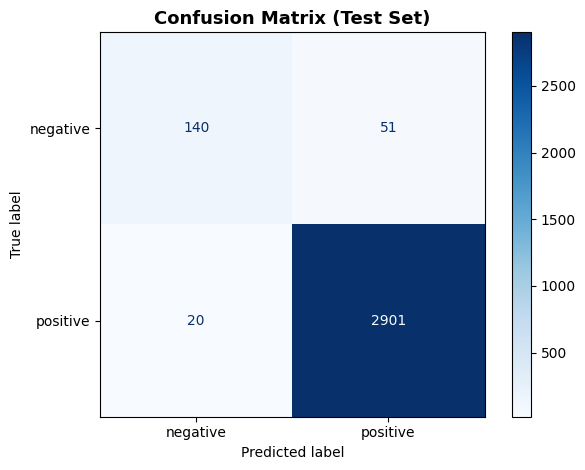

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
print("\nConfusion matrix saved to confusion_matrix.png")